In [1]:
import re
import time
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import emoji

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import data 


from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import label_binarize, LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split, learning_curve, validation_curve, KFold, GridSearchCV, LearningCurveDisplay

from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay


data.path.append (r"/home/dlcourse/data/dl_lab_2023/DIVE/data/nltk")

In [2]:
df = pd.read_csv(r"/home/dlcourse/data/dl_lab_2023/DIVE/data/drug_text_data/train.csv")

In [3]:
df.head()

,unique_hash,text,drug,sentiment
0,2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0,Autoimmune diseases tend to come in clusters. ...,gilenya,2
1,9eba8f80e7e20f3a2f48685530748fbfa95943e4,I can completely understand why you’d want to ...,gilenya,2
2,fe809672251f6bd0d986e00380f48d047c7e7b76,Interesting that it only targets S1P-1/5 recep...,fingolimod,2
3,bd22104dfa9ec80db4099523e03fae7a52735eb6,"Very interesting, grand merci. Now I wonder wh...",ocrevus,2
4,b227688381f9b25e5b65109dd00f7f895e838249,"Hi everybody, My latest MRI results for Brain ...",gilenya,1


In [4]:
print(df.isnull().sum())

unique_hash    0
text           0
drug           0
sentiment      0
dtype: int64


In [5]:
print(df.nunique())

unique_hash    5279
text           5181
drug            102
sentiment         3
dtype: int64


In [6]:
df.drop(columns=["unique_hash", "sentiment"], inplace=True)

In [7]:
print(df.head())

                                                text        drug
0  Autoimmune diseases tend to come in clusters. ...     gilenya
1  I can completely understand why you’d want to ...     gilenya
2  Interesting that it only targets S1P-1/5 recep...  fingolimod
3  Very interesting, grand merci. Now I wonder wh...     ocrevus
4  Hi everybody, My latest MRI results for Brain ...     gilenya


In [8]:
print(df.nunique())

text    5181
drug     102
dtype: int64


In [9]:
duplicated_df = df[df.duplicated(subset="text")]
print(duplicated_df.nunique())

text    88
drug    38
dtype: int64


In [10]:
counts = df["drug"].value_counts()[:10]
print(counts)
print("total:", counts.sum())

drug
ocrevus        676
gilenya        666
ocrelizumab    441
entyvio        303
humira         270
fingolimod     238
remicade       229
opdivo         224
tarceva        218
cladribine     200
Name: count, dtype: int64
total: 3465


In [11]:
data =pd.DataFrame(columns=['text', 'drug'])
for i in range(10):
    data = pd.concat([data, df[df["drug"] == counts.index[i]]])
data

,text,drug
3,"Very interesting, grand merci. Now I wonder wh...",ocrevus
19,Good luck Reg. A few days ago i went to listen...,ocrevus
52,"Combine clemastine fumarate with biotin , ocre...",ocrevus
59,Ocrevus once fully licensed here should be the...,ocrevus
61,Not sure if it in oz whats Ocrevus do for us i...,ocrevus
...,...,...
5178,"All going horribly, I'm afraid. The last day o...",cladribine
5211,1. Have you seen patients who have had Cladrib...,cladribine
5222,"Sue, don't forget we talked about this before ...",cladribine
5237,Just took 2nd dose – easily tolerated. Took 1s...,cladribine


In [12]:
labels = ['ocrevus','gilenya','ocrelizumab','entyvio','humira','fingolimod','remicade','opdivo','tarceva','cladribine']

In [13]:
stop = stopwords.words('english')
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [14]:
def clean_data(raw_data):
    soup = BeautifulSoup(raw_data, 'html.parser')
    text = soup.get_text()
    text = emoji.demojize(text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = text.split()
    meaningful_text = [w for w in text if not w in stop]
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(w) for w in meaningful_text]
    return( ' '.join(lemmatized_words))

In [15]:
data["updated_text"] = data["text"].apply(clean_data)

/tmp/ipykernel_13414/3383124658.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(raw_data, 'html.parser')


In [16]:
X = data['updated_text']
y = data['drug']

In [17]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=47)

In [18]:
vectorizer = TfidfVectorizer().fit(train_X)
X = vectorizer.transform(X)
train_X = vectorizer.transform(train_X)
test_X = vectorizer.transform(test_X)

In [19]:
label_encoder = LabelEncoder().fit(labels)
train_y = label_encoder.transform(train_y)
test_y = label_encoder.transform(test_y)

In [20]:
binarized_y = label_binarize(test_y,classes=list(range(10)))

In [21]:
clf = ComplementNB()

In [22]:
kf = KFold(n_splits=5, shuffle=True, random_state=47)

In [23]:
train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(clf, X, y, cv=kf, scoring="accuracy", return_times=True)

In [25]:
clf.fit(train_X, train_y)

ComplementNB()

In [26]:
pred_y = clf.predict(test_X)

In [27]:
probs_y = clf.predict_proba(test_X)

In [28]:
print(classification_report(test_y, pred_y, target_names=labels))

              precision    recall  f1-score   support

     ocrevus       1.00      0.43      0.60        35
     gilenya       0.54      0.75      0.63        60
 ocrelizumab       0.88      0.40      0.55        55
     entyvio       0.67      0.93      0.78       120
      humira       0.69      0.65      0.67        48
  fingolimod       0.78      0.76      0.77        95
    remicade       0.75      0.92      0.83       140
      opdivo       0.93      0.95      0.94        44
     tarceva       0.85      0.20      0.33        54
  cladribine       1.00      0.86      0.92        42

    accuracy                           0.74       693
   macro avg       0.81      0.69      0.70       693
weighted avg       0.78      0.74      0.72       693



In [29]:
matrix = ConfusionMatrixDisplay(confusion_matrix(test_y, pred_y), display_labels=labels)

<Figure size 1200x1200 with 0 Axes>

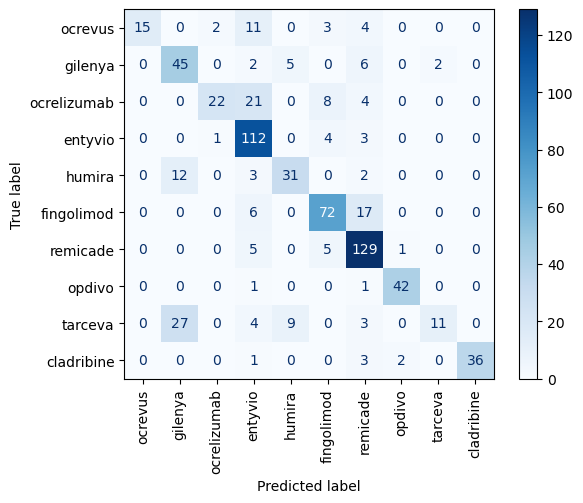

In [30]:
plt.figure(figsize=(12, 12))
matrix.plot(cmap="Blues")
plt.xticks(rotation=90)
plt.show()

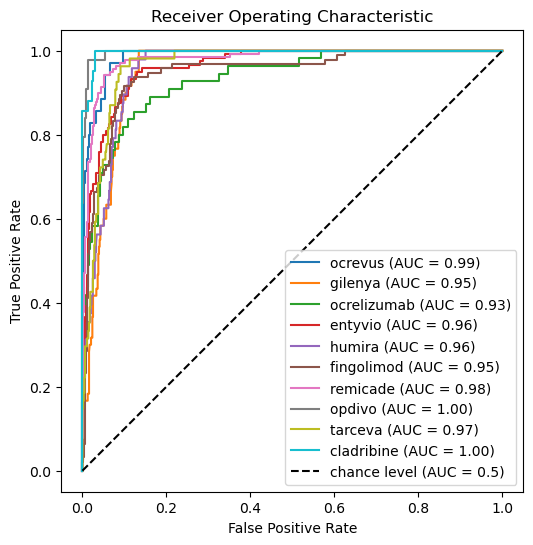

In [31]:
fig, ax = plt.subplots(figsize=(6, 6))

for label in range(10):
    RocCurveDisplay.from_predictions(
        binarized_y[:, label],
        probs_y[:, label],
        name=f"{labels[label]}",
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend()
plt.show()

In [32]:
models = {
    "LogisticRegression": LogisticRegression(),
    "SVC": SVC(probability=True),
    "DecisionTree": DecisionTreeClassifier()
}

In [33]:
preds = defaultdict()
probs = defaultdict()
train_sizes = defaultdict()
train_scores = defaultdict()
test_scores = defaultdict()
fit_times = defaultdict()
score_times = defaultdict()

In [34]:
for model_name, model in models.items():
    clf = model
    clf.fit(train_X, train_y)
    preds[model_name] = clf.predict(test_X)
    probs[model_name] = clf.predict_proba(test_X)
    train_sizes[model_name], train_scores[model_name], test_scores[model_name], fit_times[model_name], score_times[model_name] = learning_curve(clf, X, y, cv=kf, scoring="accuracy", return_times=True)

In [35]:
for model_name in models.keys():
    print(model_name)
    print(classification_report(test_y, preds[model_name], target_names=labels))

LogisticRegression
              precision    recall  f1-score   support

     ocrevus       0.90      0.77      0.83        35
     gilenya       0.73      0.75      0.74        60
 ocrelizumab       0.92      0.64      0.75        55
     entyvio       0.80      0.95      0.87       120
      humira       0.66      0.85      0.75        48
  fingolimod       0.85      0.91      0.88        95
    remicade       0.87      0.91      0.89       140
      opdivo       0.96      0.98      0.97        44
     tarceva       0.87      0.48      0.62        54
  cladribine       1.00      0.88      0.94        42

    accuracy                           0.84       693
   macro avg       0.86      0.81      0.82       693
weighted avg       0.85      0.84      0.83       693

SVC
              precision    recall  f1-score   support

     ocrevus       0.90      0.77      0.83        35
     gilenya       0.71      0.75      0.73        60
 ocrelizumab       0.92      0.60      0.73        55
 

LogisticRegression


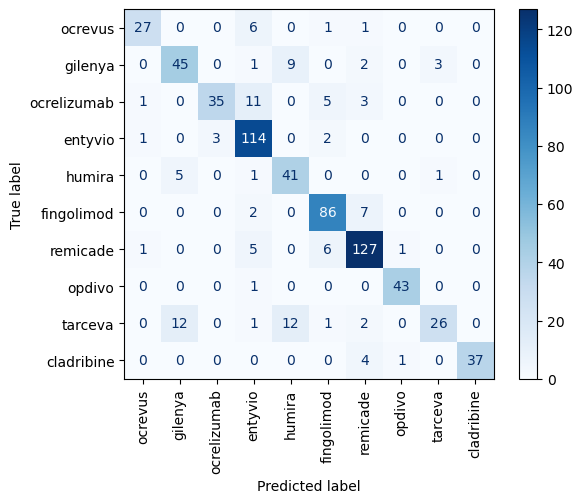

SVC


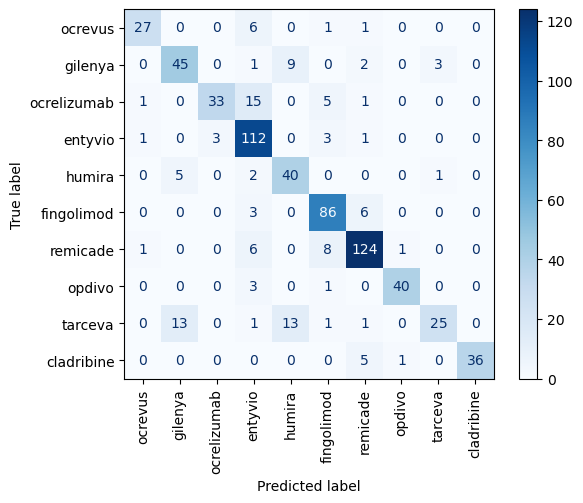

DecisionTree


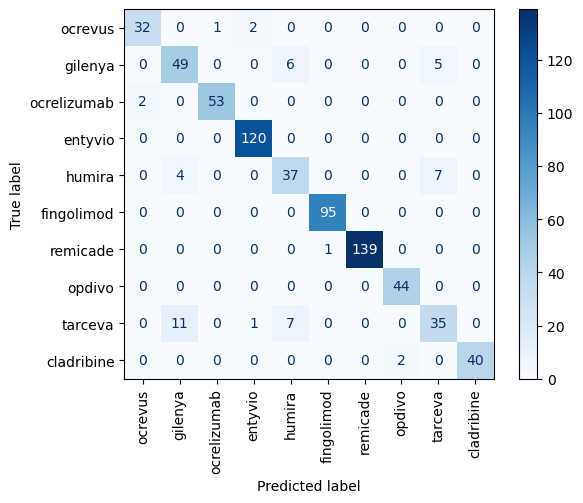

In [36]:
for model_name in models.keys():
    print(model_name)
    matrix = ConfusionMatrixDisplay(confusion_matrix(test_y, preds[model_name]), display_labels=labels)
    matrix.plot(cmap="Blues")
    plt.xticks(rotation=90)
    plt.show()

LogisticRegression


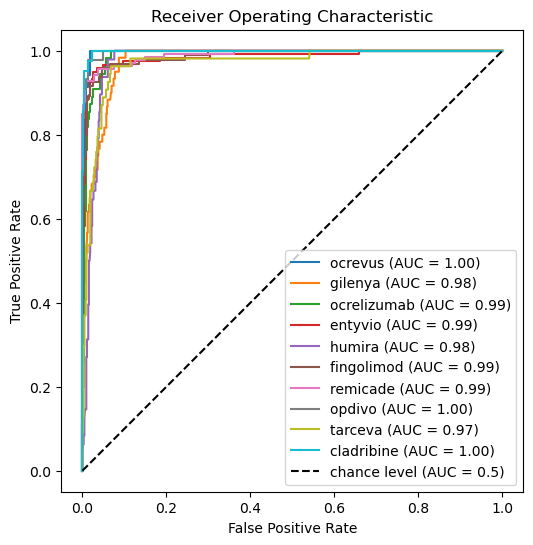

SVC


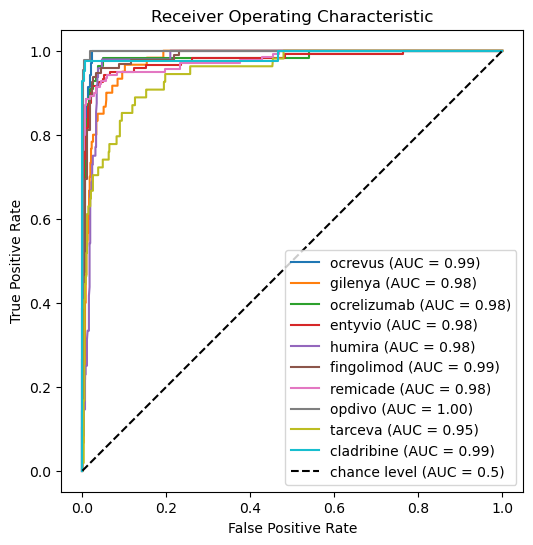

DecisionTree


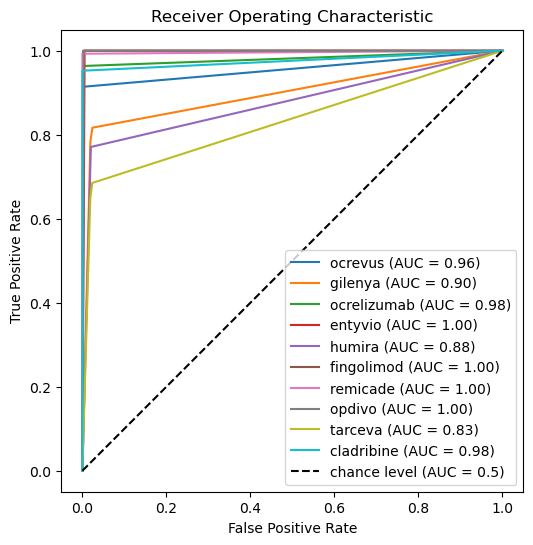

In [37]:
for model_name in models.keys():
    print(model_name)
    fig, ax = plt.subplots(figsize=(6, 6))
    for label in range(10):
        RocCurveDisplay.from_predictions(
            binarized_y[:, label],
            probs[model_name][:, label],
            name=f"{labels[label]}",
            ax=ax,
        )

    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend()
    plt.show()